## Topic Modeling IMDB Movie Reviews
### DS 7337 - Natural Laguage Processing - FInal Project
#### George C. Sturrock
##### April 14, 2019
##### Resources
https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/
#### Import Libraries

In [1]:
import platform; print("Platform:", platform.platform())
import os
import sys; print("Python:", sys.version)
import requests; print("Requests:", requests.__version__)
from urllib import request; ("urllib:", request.__version__)
import warnings
warnings.filterwarnings('ignore')
from time import sleep

#Web Scraping
import bs4; print("BeatifulSoup:", bs4.__version__)
from bs4 import BeautifulSoup
import json; print("json:", json.__version__)

#Python Basics
import numpy as np; print("Numpy Version:", np.__version__)
import pandas as pd; print("Pandas Version:", pd.__version__)
from matplotlib import pyplot as plt
import seaborn as sns;
import string

#scikit learn
from sklearn import metrics
from sklearn.feature_extraction import stop_words
#print(stop_words.ENGLISH_STOP_WORDS)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.model_selection import GridSearchCV

import pattern; print("Pattern Version:", pattern.__version__)
from pattern.en import tag, parse, Sentence
from pattern.en import parsetree
from pattern.en import sentiment, positive
from pattern.vector import Document, Model, TFIDF, TF
from pattern.vector import words, stem, PORTER, LEMMA

#pyLDAvis
import pyLDAvis; print("pyLDAvis Versoin:", pyLDAvis.__version__)
import pyLDAvis.sklearn

Platform: Windows-10-10.0.14393-SP0
Python: 3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]
Requests: 2.21.0
BeatifulSoup: 4.7.1
json: 2.0.9
Numpy Version: 1.16.2
Pandas Version: 0.24.2
Pattern Version: 3.6
pyLDAvis Versoin: 2.1.2


### Data Acquisition
The first three films in the "Rocky" series will be utilized to collect reviews for noun phrase chunking.  Link to the main user review page for each of the three movies are shown below.  To assure both positive and negative reviews are collected, there are two links per movie.  One is sorted descending by user rating.  The other is sorted ascending by user rating.  Both links have "spoiler alert" messages suppressed as these reviews are often more akin to a summarization of the movie plot instead of a true review.  

In [2]:
#Rocky movie list.  Two links for each movie to assure positive and negative reviews are captured.  
#Sort descending by Review Rating.  Sort ascending by Review Rating.

#Rocky
rockyDict = {"aRocky":"https://www.imdb.com/title/tt0075148/reviews?spoiler=hide&sort=userRating&dir=asc&ratingFilter=0", 
         "dRocky":"https://www.imdb.com/title/tt0075148/reviews?spoiler=hide&sort=userRating&dir=desc&ratingFilter=0", 
#Rocky 2
         "dRocky 2":"https://www.imdb.com/title/tt0079817/reviews?spoiler=hide&sort=userRating&dir=desc&ratingFilter=0",
         "aRocky 2":"https://www.imdb.com/title/tt0079817/reviews?spoiler=hide&sort=userRating&dir=asc&ratingFilter=0",
#Rocky 3
         "dRocky 3":"https://www.imdb.com/title/tt0084602/reviews?spoiler=hide&sort=userRating&dir=desc&ratingFilter=0",
         "aRocky 3":"https://www.imdb.com/title/tt0084602/reviews?spoiler=hide&sort=userRating&dir=asc&ratingFilter=0"
            }

rockyKeys = rockyDict.keys()

#### Web Scraping IMDB Movie Review Titles
The individual links to the user reviews are collected below.  A get request uses each of the links in the "rockyDict" python dictionary.  The response is parsed by Beautiful Soup to find the individual links to each individual review.  The review URLs along with the movie name are written to a dataframe named dfRockyReviews.

In [3]:
reviewUrls = list()
dfRockyReviews = pd.DataFrame(columns = ['Movie', 'ReviewURL'])

for r in rockyKeys:
    #print(r, rockyDict[r])
    response = requests.get(rockyDict[r])
    soup = BeautifulSoup(response.text, 'html.parser')
    rUrls = ["http:" + s.attrs['href'] for s in soup.find_all(href = True, class_ = 'title')]
    reviewUrls = reviewUrls + rUrls
    for u in rUrls:
        dfRockyReviews = dfRockyReviews.append({'Movie':r[1:], 'ReviewURL':u}, ignore_index=True)

A sample of the dfRockyReviews dataframe is shown below.

In [4]:
dfRockyReviews[0:5]

,Movie,ReviewURL
0,Rocky,http:/review/rw0149538/
1,Rocky,http:/review/rw4247059/
2,Rocky,http:/review/rw0149534/
3,Rocky,http:/review/rw1979442/
4,Rocky,http:/review/rw3451942/


#### Web Scraping IMDB Movie Review Details
The individual review URLs collected above will be requested and parsed to retrieve key qualitative and categorical data about each review along with the review text itself.  These details are stored in a new dataframe named dfReviewDetails.  The first five records are this dataframe are shown below.

In [5]:
dfReviewDetails = pd.DataFrame(columns=['Movie', 'ReviewUrl', 'ReviewDate', 'ReviewTitle', 'Review', 'Rating', 
                                        'Language'])
counter = 0

for r in reviewUrls:
    fullUrl = "https://www.imdb.com" + r[5:]
    response2 = requests.get(fullUrl)
    soup2 = BeautifulSoup(response2.text, 'html.parser')
    rjson = soup2.find('script', type = 'application/ld+json').text
    rjson = json.loads(rjson)
    
    try:
        rating = rjson['reviewRating']['ratingValue']
    except Exception as e:
        #print("No User Rating")
        rating = 5
        
    ### Add stemming logic to review body
    
    dfReviewDetails = dfReviewDetails.append({'Movie':dfRockyReviews.Movie[counter], 'ReviewUrl':r, 
                                              'ReviewDate':rjson['dateCreated'], 'ReviewTitle':rjson['name'], 
                                              'Review':rjson['reviewBody'], 'Rating':rating, 
                                              'Language':rjson['inLanguage']}, ignore_index=True)
    counter += 1

dfReviewDetails.head()

,Movie,ReviewUrl,ReviewDate,ReviewTitle,Review,Rating,Language
0,Rocky,http:/review/rw0149538/,1999-11-25,"Dumbest, Most Cornball Film Ever Made",I still remember my initial outrage that this ...,1,English
1,Rocky,http:/review/rw4247059/,2018-07-21,Rubbish,The fight scenes are pathetic and the acting i...,1,English
2,Rocky,http:/review/rw0149534/,1998-08-19,overrated piece of cheese,grubby late-night fare achieved way too much s...,2,English
3,Rocky,http:/review/rw1979442/,2008-11-22,The most overrated movie of all time,I went to see this movie when it came out. I h...,3,English
4,Rocky,http:/review/rw3451942/,2016-04-15,Hate me if you want but I didn't like this film,I'm going to come out and say it. I didn't lik...,3,English


The bar plot below shows movie review ratings for the reviews collected in the prior step. The original "Rocky" is widely considered the best of the "Rocky" series.  It won multiple Oscars and introduced "Steady-Cam" technology to the movie world.  However, the sample of user reviews collected tell a different story.  

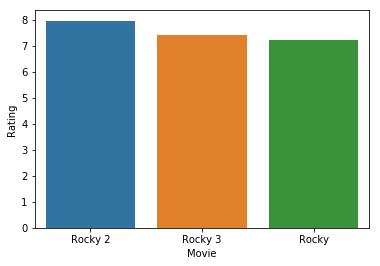

In [6]:
plotdf = dfReviewDetails.sort_values(by=['ReviewDate'])
plotdf.Rating = plotdf.Rating.astype('int64')
plotdf.ReviewDate = pd.to_datetime(plotdf.ReviewDate)
plotdf = plotdf.groupby(['Movie']).mean().reset_index()
sns.barplot(x='Movie', y='Rating', data=plotdf.sort_values(by=['Rating'], ascending=False))

### Data Cleansing

#### Vectorize Reviews

In [11]:
tfidfVectorizer = TfidfVectorizer(max_df=1, min_df=0, stop_words='english', use_idf=True, ngram_range=(1,3))
countVectorizer = CountVectorizer(analyzer='word', min_df=7, stop_words='english', lowercase=True)

In [12]:
tfidfMatrix = tfidfVectorizer.fit_transform(dfReviewDetails.Review)
tfidfMatrix.shape

(150, 29421)

In [13]:
cvMatrix = countVectorizer.fit_transform(dfReviewDetails.Review)
cvMatrix.shape

(150, 353)

In [14]:
#sparceness
cvDense = cvMatrix.todense()
print("Sparseness: ", ((cvDense > 0).sum()/cvDense.size)*100, "%")

Sparseness:  11.244570349386214 %


##### LDA Model GridSearchCV

In [20]:
lda = LatentDirichletAllocation()

parmGrid = {'n_components': [3, 5, 7, 9, 11], 
            'learning_method': ['online'], 
            'random_state': [2019], 
            'learning_decay': [0.5, 0.7, 0.9], 
            'max_iter': [5, 10]}

ldaGrid = GridSearchCV(lda, param_grid=parmGrid)

In [21]:
ldaGrid.fit(cvMatrix)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_components': [3, 5, 7, 9, 11], 'learning_method': ['online'], 'random_state': [2019], 'learning_decay': [0.5, 0.7, 0.9], 'max_iter': [5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [22]:
print("Best Estimator:", ldaGrid.best_estimator_)
print(ldaGrid.best_params_)

Best Estimator: LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.9,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=3, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=2019, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)
{'learning_decay': 0.9, 'learning_method': 'online', 'max_iter': 10, 'n_components': 3, 'random_state': 2019}


#### LDA Model

In [31]:
## Original trained model
#
#lda = LatentDirichletAllocation(n_topics=10, max_iter=5, learning_method='online', random_state=2019, batch_size=120, 
#                               evaluate_every=-1, n_jobs=-1)
#
#ldaFit = lda.fit_transform(cvMatrix)
ldaBest = LatentDirichletAllocation(n_components=7, max_iter=5, learning_method='online', learning_decay=0.9, random_state=2019, batch_size=120, 
                                    evaluate_every=-1, n_jobs=-1)
ldaBestFit = ldaBest.fit_transform(cvMatrix)

In [32]:
print("Log Likelihood:", ldaBest.score(cvMatrix))
print("Perplexity:", ldaBest.perplexity(cvMatrix))

Log Likelihood: -49783.02045106632
Perplexity: 273.65924928958503


##### LDA Model Scoring

Original Model

print("Log Likelihood:", lda.score(cvMatrix))

print("Perplexity:", lda.perplexity(cvMatrix))

Log Likelihood: -65854.02334362216

Perplexity: 456.28047756163363

In [33]:
#print("Log Likelihood:", lda.score(cvMatrix))
#print("Perplexity:", lda.perplexity(cvMatrix))

#### pyLDAvis Plotting

In [34]:
pyLDAvis.enable_notebook()
#panel = pyLDAvis.sklearn.prepare(lda, cvMatrix, countVectorizer, mds='tsne')
panel = pyLDAvis.sklearn.prepare(ldaBest, cvMatrix, countVectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
5     -75.647682  43.218079       1        1  67.548150
4     -53.771984  54.570892       2        1  19.857004
1     -54.882996  29.950241       3        1  11.385820
3     -76.753342  18.603716       4        1   0.505052
0     -33.006874  41.297489       5        1   0.234682
2     -34.121826  16.681051       6        1   0.234659
6     -55.993465   5.335084       7        1   0.234632, topic_info=    Category        Freq       Term       Total  loglift  logprob
243  Default  710.000000      rocky  710.000000  30.0000  30.0000
100  Default  250.000000       film  250.000000  29.0000  29.0000
195  Default  215.000000      movie  215.000000  28.0000  28.0000
285  Default  152.000000   stallone  152.000000  27.0000  27.0000
149  Default  118.000000       just  118.000000  26.0000  26.0000
306  Default  111.000000       time  111.000000  25.0000  25.0000
101  Default   73.000000      films   73.000000  24.0000  24.0000
96   Default  123.000000      fight  123.000000  23.0000  23.0000
156  Default   97.000000       like   97.000000  22.0000  22.0000
117  Default  100.000000       good  100.000000  21.0000  21.0000
289  Default   80.000000      story   80.000000  20.0000  20.0000
54   Default  103.000000      creed  103.000000  19.0000  19.0000
294  Default   65.000000  sylvester   65.000000  18.0000  18.0000
119  Default   58.000000      great   58.000000  17.0000  17.0000
12   Default  107.000000     apollo  107.000000  16.0000  16.0000
196  Default   61.000000     movies   61.000000  15.0000  15.0000
153  Default   78.000000       lang   78.000000  14.0000  14.0000
236  Default   56.000000     really   56.000000  13.0000  13.0000
8    Default   60.000000     adrian   60.000000  12.0000  12.0000
17   Default   75.000000     balboa   75.000000  11.0000  11.0000
28   Default   64.000000     boxing   64.000000  10.0000  10.0000
21   Default   53.000000       best   53.000000   9.0000   9.0000
139  Default   82.000000        iii   82.000000   8.0000   8.0000
41   Default   55.000000  character   55.000000   7.0000   7.0000
268  Default   59.000000     series   59.000000   6.0000   6.0000
69   Default   50.000000        don   50.000000   5.0000   5.0000
197  Default   76.000000         mr   76.000000   4.0000   4.0000
45   Default   58.000000    clubber   58.000000   3.0000   3.0000
187  Default   56.000000     mickey   56.000000   2.0000   2.0000
170  Default   45.000000       love   45.000000   1.0000   1.0000
..       ...         ...        ...         ...      ...      ...
258   Topic7    0.065945     script   11.920747   0.8577  -5.7546
81    Topic7    0.065600     entire   11.689536   0.8720  -5.7598
306   Topic7    0.115817       time  111.930842  -0.8187  -5.1914
121   Topic7    0.077241        guy   23.360534   0.3430  -5.5965
262   Topic7    0.068333       self   15.110721   0.6561  -5.7190
297   Topic7    0.077345      talia   29.196779   0.1214  -5.5951
242   Topic7    0.083096       ring   51.382046  -0.3721  -5.5234
243   Topic7    0.116676      rocky  710.160620  -2.6589  -5.1840
22    Topic7    0.075736     better   34.713584  -0.0727  -5.6161
334   Topic7    0.076074       wife   38.013223  -0.1591  -5.6117
38    Topic7    0.075799   champion   37.860925  -0.1587  -5.6153
16    Topic7    0.077490        bad   46.936075  -0.3515  -5.5932
117   Topic7    0.084363       good  100.716298  -1.0300  -5.5083
170   Topic7    0.076778       love   45.287497  -0.3250  -5.6025
100   Topic7    0.091093       film  250.169793  -1.8631  -5.4315
329   Topic7    0.072182   watching   29.032590   0.0579  -5.6642
264   Topic7    0.072542     sequel   31.623212  -0.0226  -5.6592
28    Topic7    0.076592     boxing   64.890887  -0.6871  -5.6049
8     Topic7    0.075884     adrian   60.275318  -0.6226  -5.6142
289   Topic7    0.075968      story   80.426980  -0.9099  -5.6131
101   Topic7    0.075